# Vector Autoregressive

- Tesla causes Meta, Ford, Palladium
- Apple causes Microsoft, NVIDIA, Amazon, Meta, Gold, Palladium
- Google causes Microsoft, Amazon, Meta, Oil, Ford, Palladium
- Microsoft causes Apple, Google, Amazon, Meta, Gold, Ford, Palladium
- NVIDIA causes Google, Microsoft, Amazon, Meta, Gold
- Amazon causes Tesla, TGold, Ford, Palladium
- Meta causes Amazon, TSMC, Ford, Palladium
- TSMC causes Apple, Gold, Ford, Palladium
- Gold causes Oil, Palladium
- Oil causes Google, Microsoft, Gold, Palladium
- Ford causes Tesla, NVIDIA, TSMC, Gold, Oil, Palladium
- Palladium causes Tesla

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import acf, pacf, grangercausalitytests
from statsmodels.tsa.statespace.varmax import VARMAX

## Import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

import yfinance as yf

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
tesla = yf.Ticker("TSLA")
palladium = yf.Ticker("PA=F")

tesla_data = tesla.history(start='2020-08-01', end='2024-10-24')
palladium_data = palladium.history(start='2020-08-01', end='2024-10-24')

In [4]:
tesla_data['closeDiff'] = tesla_data.Close.diff()
palladium_data['closeDiff'] = palladium_data.Close.diff()

In [5]:
tesla_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,closeDiff
Date,,,,,,,,
2020-08-03 00:00:00-04:00,96.613335,100.653999,96.292000,99.000000,132139500,0.0,0.0,NaN
2020-08-04 00:00:00-04:00,99.667336,101.827332,97.466667,99.133331,126225000,0.0,0.0,0.133331
2020-08-05 00:00:00-04:00,99.532669,99.989334,97.887337,99.001335,74217000,0.0,0.0,-0.131996
2020-08-06 00:00:00-04:00,99.388664,101.153999,98.484001,99.305336,89884500,0.0,0.0,0.304001
2020-08-07 00:00:00-04:00,99.969330,99.983330,94.334000,96.847336,133446000,0.0,0.0,-2.458000
...,...,...,...,...,...,...,...,...
2024-10-17 00:00:00-04:00,221.589996,222.080002,217.899994,220.889999,50791800,0.0,0.0,-0.440002
2024-10-18 00:00:00-04:00,220.710007,222.279999,219.229996,220.699997,49611900,0.0,0.0,-0.190002
2024-10-21 00:00:00-04:00,218.899994,220.479996,215.729996,218.850006,47329000,0.0,0.0,-1.849991


In [6]:
palladium_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,closeDiff
Date,,,,,,,,
2020-08-03 00:00:00-04:00,2129.699951,2129.699951,2129.699951,2129.699951,0,0.0,0.0,NaN
2020-08-04 00:00:00-04:00,2161.000000,2161.000000,2161.000000,2161.000000,0,0.0,0.0,31.300049
2020-08-05 00:00:00-04:00,2207.600098,2207.600098,2207.600098,2207.600098,0,0.0,0.0,46.600098
2020-08-06 00:00:00-04:00,2251.800049,2251.800049,2251.800049,2251.800049,0,0.0,0.0,44.199951
2020-08-07 00:00:00-04:00,2172.600098,2172.600098,2172.600098,2172.600098,0,0.0,0.0,-79.199951
...,...,...,...,...,...,...,...,...
2024-10-17 00:00:00-04:00,1038.300049,1038.300049,1038.300049,1038.300049,12,0.0,0.0,19.300049
2024-10-18 00:00:00-04:00,1077.699951,1077.699951,1077.699951,1077.699951,12,0.0,0.0,39.399902
2024-10-21 00:00:00-04:00,1048.400024,1048.400024,1048.400024,1048.400024,12,0.0,0.0,-29.299927


## Stationary test

In [7]:
df = pd.DataFrame()
df['Tesla Diff'] = tesla_data['closeDiff'].copy()
df['Palladium Diff'] = palladium_data['closeDiff'].copy()

## Palladium Diff causes Tesla Diff

In [8]:
grangercausalitytests(df[['Tesla Diff', 'Palladium Diff']].dropna(), maxlag=15) #, verbose = False)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6385  , p=0.0567  , df_denom=1059, df_num=1
ssr based chi2 test:   chi2=3.6488  , p=0.0561  , df=1
likelihood ratio test: chi2=3.6425  , p=0.0563  , df=1
parameter F test:         F=3.6385  , p=0.0567  , df_denom=1059, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2224  , p=0.1089  , df_denom=1056, df_num=2
ssr based chi2 test:   chi2=4.4659  , p=0.1072  , df=2
likelihood ratio test: chi2=4.4565  , p=0.1077  , df=2
parameter F test:         F=2.2224  , p=0.1089  , df_denom=1056, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8207  , p=0.0379  , df_denom=1053, df_num=3
ssr based chi2 test:   chi2=8.5185  , p=0.0364  , df=3
likelihood ratio test: chi2=8.4844  , p=0.0370  , df=3
parameter F test:         F=2.8207  , p=0.0379  , df_denom=1053, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.7766  , p=0.

{np.int64(1): ({'ssr_ftest': (np.float64(3.6384520934732127),
    np.float64(0.05672970447801727),
    np.float64(1059.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(3.6487593231997657),
    np.float64(0.05611099511282359),
    np.int64(1)),
   'lrtest': (np.float64(3.642505543266452),
    np.float64(0.05632211420529374),
    np.int64(1)),
   'params_ftest': (np.float64(3.6384520934727798),
    np.float64(0.056729704478033015),
    np.float64(1059.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(2.2224059776545686),
    np.float64(0.1088546368332263),
    np.float64(1056.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(4.465857466461168),
    np.float64(0.1072139687607369),
    np.int64(2)),
   'lrtest': (np.float64(4.4564851313571126),
    np.float64(0.10771757044159788),
    np.int64(2)),
   'params_ftest': (np.float64(2.2224059776543257),
    np.float64(0.1088546368332453),
    np.float64(1056.0),
    2.0)},
   array([[0., 0., 1., 0., 0.]

Granger Causality test detects strongest causality (Palladium causes Tesla) at lag = 4 (F = 2.7869, p = 0.0253). Thus, lag 4 would be our optimal lag.

In [9]:
df = df.dropna()

In [10]:
df

,Tesla Diff,Palladium Diff
Date,,
2020-08-04 00:00:00-04:00,0.133331,31.300049
2020-08-05 00:00:00-04:00,-0.131996,46.600098
2020-08-06 00:00:00-04:00,0.304001,44.199951
2020-08-07 00:00:00-04:00,-2.458000,-79.199951
2020-08-10 00:00:00-04:00,-2.276001,92.599854
...,...,...
2024-10-17 00:00:00-04:00,-0.440002,19.300049
2024-10-18 00:00:00-04:00,-0.190002,39.399902
2024-10-21 00:00:00-04:00,-1.849991,-29.299927


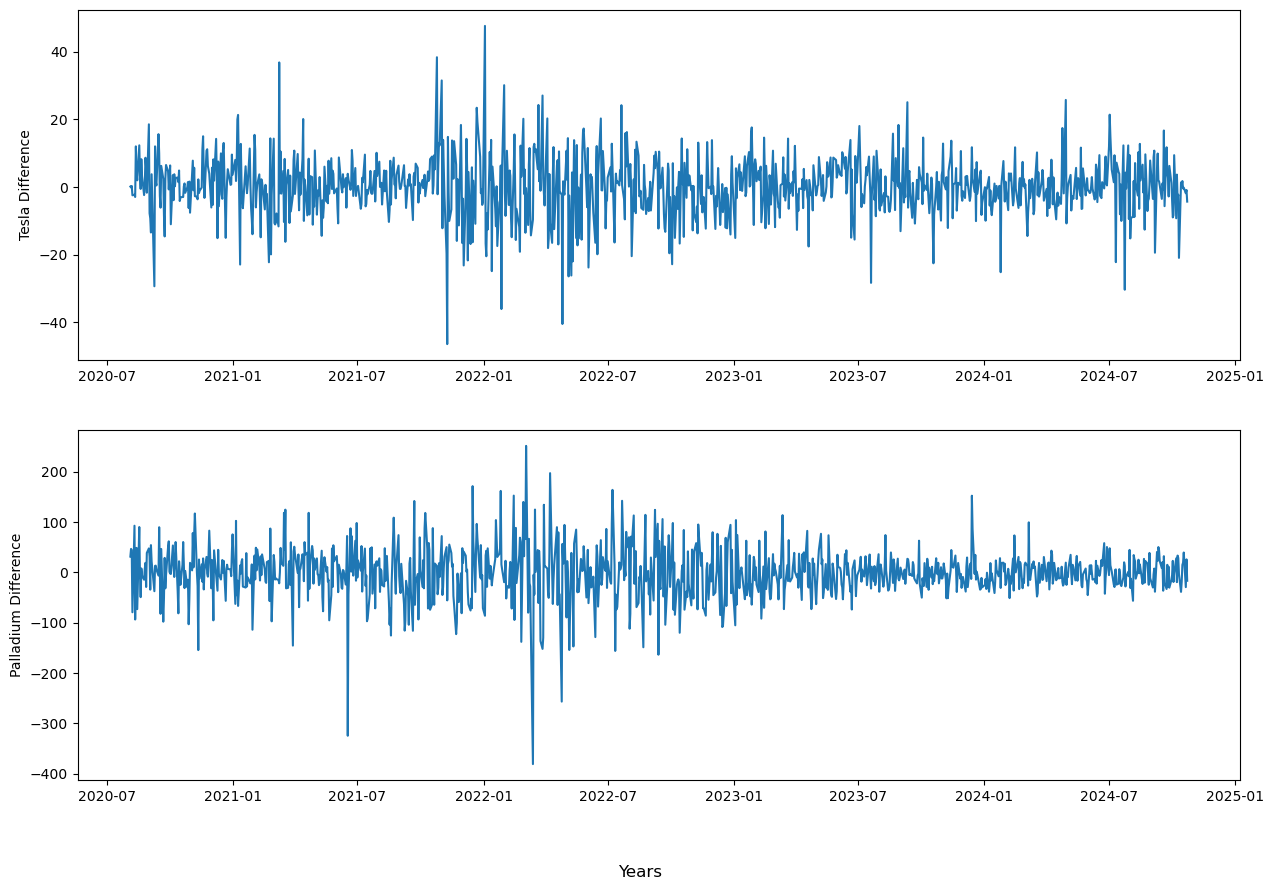

In [11]:
fig, ax = plt.subplots(2, figsize = (15, 10))
ax[0].plot(df['Tesla Diff'])
ax[1].plot(df['Palladium Diff'])
ax[0].set_ylabel('Tesla Difference')
ax[1].set_ylabel('Palladium Difference')
fig.supxlabel('Years')
plt.show()

In [12]:
kfold = TimeSeriesSplit(n_splits = 5,
                           test_size = 14)

In [13]:
#forecast_length = 5
#train_df, test_df = df.iloc[:-forecast_length], df.iloc[-forecast_length:]

In [14]:
#df = df.reset_index()

In [15]:
forecast_length = 24
train = df.iloc[:-forecast_length]
test = df.iloc[-forecast_length:]
#df.index = pd.DatetimeIndex(df.index).to_period('M')

In [16]:
#train = train.reset_index()

In [17]:
train

,Tesla Diff,Palladium Diff
Date,,
2020-08-04 00:00:00-04:00,0.133331,31.300049
2020-08-05 00:00:00-04:00,-0.131996,46.600098
2020-08-06 00:00:00-04:00,0.304001,44.199951
2020-08-07 00:00:00-04:00,-2.458000,-79.199951
2020-08-10 00:00:00-04:00,-2.276001,92.599854
...,...,...
2024-09-13 00:00:00-04:00,0.479996,22.199951
2024-09-16 00:00:00-04:00,-3.509995,8.400024
2024-09-17 00:00:00-04:00,1.089996,20.299927


In [18]:
#test = test.reset_index()

In [19]:
test

,Tesla Diff,Palladium Diff
Date,,
2024-09-20 00:00:00-04:00,-5.669998,-20.500000
2024-09-23 00:00:00-04:00,11.750000,-33.000000
2024-09-24 00:00:00-04:00,4.270004,15.000000
2024-09-25 00:00:00-04:00,2.749985,-28.599976
2024-09-26 00:00:00-04:00,-2.799988,11.000000
2024-09-27 00:00:00-04:00,6.239990,-30.300049
2024-09-30 00:00:00-04:00,1.170013,-15.099976
2024-10-01 00:00:00-04:00,-3.610016,-5.300049
2024-10-02 00:00:00-04:00,-8.999985,22.800049


In [20]:
#model = VAR(train.drop(columns=['Date']))
model = VAR(train)
sorted_order = model.select_order(maxlags = 10)
sorted_order.summary()
#results = model.fit(4)
#lag_order = results.k_ar

C:\Users\teres\anaconda3\envs\equity_vs_commodity\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,12.23,12.24*,2.055e+05,12.24*
1,12.23*,12.26,2.055e+05*,12.24
2,12.24,12.29,2.069e+05,12.26
3,12.24,12.31,2.067e+05,12.26
4,12.24,12.33,2.069e+05,12.27
5,12.24,12.35,2.073e+05,12.28
6,12.24,12.37,2.079e+05,12.29
7,12.24,12.39,2.078e+05,12.30
8,12.24,12.41,2.076e+05,12.31
9,12.24,12.43,2.077e+05,12.31


In [33]:
var_model = model.fit(4)
forecast_var = pd.DataFrame(var_model.forecast(train.values, 
                                              steps=forecast_length), 
                           columns=train.columns, 
                           index=test.index)
forecast_var = pd.concat([forecast_var, test], axis = 1)

In [34]:
forecast_var

,Tesla Diff,Palladium Diff,Tesla Diff,Palladium Diff
Date,,,,
2024-09-20 00:00:00-04:00,-0.506838,4.127315,-5.669998,-20.500000
2024-09-23 00:00:00-04:00,-0.270940,-0.637347,11.750000,-33.000000
2024-09-24 00:00:00-04:00,0.619768,-6.118435,4.270004,15.000000
2024-09-25 00:00:00-04:00,0.900738,-3.262141,2.749985,-28.599976
2024-09-26 00:00:00-04:00,0.094727,-0.758935,-2.799988,11.000000
2024-09-27 00:00:00-04:00,0.077794,-1.066719,6.239990,-30.300049
2024-09-30 00:00:00-04:00,0.190751,-1.192700,1.170013,-15.099976
2024-10-01 00:00:00-04:00,0.212360,-1.036774,-3.610016,-5.300049
2024-10-02 00:00:00-04:00,0.136388,-0.993478,-8.999985,22.800049


In [35]:
forecast_var['Tesla Diff']

,Tesla Diff,Tesla Diff
Date,,
2024-09-20 00:00:00-04:00,-0.506838,-5.669998
2024-09-23 00:00:00-04:00,-0.270940,11.750000
2024-09-24 00:00:00-04:00,0.619768,4.270004
2024-09-25 00:00:00-04:00,0.900738,2.749985
2024-09-26 00:00:00-04:00,0.094727,-2.799988
2024-09-27 00:00:00-04:00,0.077794,6.239990
2024-09-30 00:00:00-04:00,0.190751,1.170013
2024-10-01 00:00:00-04:00,0.212360,-3.610016
2024-10-02 00:00:00-04:00,0.136388,-8.999985


In [23]:
test

,Tesla Diff,Palladium Diff
Date,,
2024-09-20 00:00:00-04:00,-5.669998,-20.500000
2024-09-23 00:00:00-04:00,11.750000,-33.000000
2024-09-24 00:00:00-04:00,4.270004,15.000000
2024-09-25 00:00:00-04:00,2.749985,-28.599976
2024-09-26 00:00:00-04:00,-2.799988,11.000000
2024-09-27 00:00:00-04:00,6.239990,-30.300049
2024-09-30 00:00:00-04:00,1.170013,-15.099976
2024-10-01 00:00:00-04:00,-3.610016,-5.300049
2024-10-02 00:00:00-04:00,-8.999985,22.800049


In [24]:
#var_model = VARMAX(train.drop(columns='Date'), order=(2, 0), enforce_stationary = True)
#fitted_model = var_model.fit(disp=False)
#print(fitted_model.summary())

In [25]:
#predict = fitted_model.get_prediction(start=len(train), end = len(train) + test_obs)

In [26]:
#prediction = predict.predicted_mean
#prediction.column = ['Tesla Diff', 'Palladium Diff']

In [27]:
#prediction

In [28]:
#test

In [29]:
#test_vs_prediction = pd.concat(test['Tesla Diff'], prediction['Tesla Diff'], axis = 1)

In [30]:
#test_vs_prediction.plot(figsize=(12, 5))

In [31]:
#results.forecast(df.values[-lag_order:], 5)

## Tesla Diff causes Palladium Diff

In [32]:
grangercausalitytests(df[['Palladium Diff', 'Tesla Diff']].dropna(), maxlag=10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9594  , p=0.0857  , df_denom=1059, df_num=1
ssr based chi2 test:   chi2=2.9678  , p=0.0849  , df=1
likelihood ratio test: chi2=2.9637  , p=0.0852  , df=1
parameter F test:         F=2.9594  , p=0.0857  , df_denom=1059, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4685  , p=0.2307  , df_denom=1056, df_num=2
ssr based chi2 test:   chi2=2.9508  , p=0.2287  , df=2
likelihood ratio test: chi2=2.9467  , p=0.2292  , df=2
parameter F test:         F=1.4685  , p=0.2307  , df_denom=1056, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9136  , p=0.1256  , df_denom=1053, df_num=3
ssr based chi2 test:   chi2=5.7790  , p=0.1229  , df=3
likelihood ratio test: chi2=5.7633  , p=0.1237  , df=3
parameter F test:         F=1.9136  , p=0.1256  , df_denom=1053, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6225  , p=0.

{np.int64(1): ({'ssr_ftest': (np.float64(2.9594428606819836),
    np.float64(0.08566948883797265),
    np.float64(1059.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(2.9678265515054454),
    np.float64(0.08493589760180789),
    np.int64(1)),
   'lrtest': (np.float64(2.9636873711424414),
    np.float64(0.08515354368320631),
    np.int64(1)),
   'params_ftest': (np.float64(2.959442860682097),
    np.float64(0.08566948883796306),
    np.float64(1059.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(1.4684635011497496),
    np.float64(0.23074888258619605),
    np.float64(1056.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(2.950832906666448),
    np.float64(0.22868347121795382),
    np.int64(2)),
   'lrtest': (np.float64(2.946737099011443),
    np.float64(0.22915227284042344),
    np.int64(2)),
   'params_ftest': (np.float64(1.4684635011507783),
    np.float64(0.23074888258596324),
    np.float64(1056.0),
    2.0)},
   array([[0., 0., 1., 0., 0.

Granger Causality test detects strongest causality (Tesla causes Palladium) at lag = 1 (F = 3.8801, p = 0.0491). Thus, lag 1 would be our optimal lag.